# MOSFiT Module Analysis
Using 1 component rprocess model as input, specific modules are computed. We want to know what each module does and what each component does. 

r-process Model Modules:
 - parameter : ebv
 - parameter : nhhost
 - parameter : texplosion
 - parameter : temperature
 - parameter : kappa
 - parameter : kappagamma
 - parameter : frad
 - parameter : mejecta
 - parameter : vejecta
 - module : engine : rprocess
 - module : transform : diffusion
 - module : photosphere : temperature_floor
 - module : sed : blackbody
 - module : sed : losextinction
 - module : observable : photometry
 
There are other modules that need to be called in order to compute the modules in the model (listed above). Namely, `resttimes` and `densetimes` need to be called before everything else. 

We choose to look at the parameters of mejecta and vejecta and see how the physics changes, but this should be easy enough to modify to analyze any other parameter (e.g. if you were interested in kappa, make an array of kappas and iterate over kappa in plotting scripts).

Without further ado... 

## Instantiate + Import

In [1]:
import numpy as np
import mosfit
import matplotlib.pyplot as plt
import matplotlib as mpl
import json
from collections import OrderedDict
%matplotlib inline

In [2]:
# Analyzing 1-Component Kilonova Model
my_model = mosfit.model.Model(model='rprocess')

In [3]:
# Parameters
kappa = 1 # opacity
kappa_gamma = 1000 # opacity for high-energy photons

#red, middle, blue from Villar et al. 2017
frad = 0.999 # Fraction radioactive material
mejectas = np.array([.01, .015, .02]) 
vejectas = np.array([.137,.201,.266])*(mosfit.constants.C_CGS /mosfit.constants.KM_CGS)
# Values for GW170817
# These are calculated in ../notMOSFiT/mosfit/
redshift = 0.009727
lumdist = 39.5

### ....an interlude for an explanation of the observables parameters
The way the observables parameters are organizes is as one big table:

time | band | telescope | instrument | mode | measure | system | freq | u_freq | zeropt | bandset
--- |--- |--- |--- |--- |--- |--- |--- |--- |--- |--- |--- |
0.0 | u | Blanco | DECam | - | - | DECam | - | - | - | DECam
0.0 | g | Blanco | DECam | - | - | DECam | - | - | - | DECam
0.1 | u | Blanco | DECam | - | - | DECam | - | - | - | DECam
0.1 | g | Blanco | DECam | - | - | DECam | - | - | - | DECam
etc. | - | - | - | - | - |  - | - | - | - |

And the way MOSFiT stores this data is each column is an array. So we're gonna fake it and generate these arrays for each time in np.linspace(0,10,101) and for ugrizY.

Note: I actually couldn'y get this to work right unless I used only one band. So the above explanation could be straight up wrong.

In [18]:
# Actual Setting of Values
texplosion = 0
times = np.linspace(0,10,101)
bands = ['u']

# Creating MOSFiT-happy structures
all_bands = [j for i in times for j in bands]
all_times = [i for i in times for j in bands]
modes = ['' for i in times for j in bands]
measures = ['' for i in times for j in bands]
systems = ['DECam' for i in times for j in bands]
telescopes = ['Blanco' for i in times for j in bands]
instruments  = ['DECam' for i in times for j in bands]
frequencies = [None for i in times for j in bands]
u_frequencies = [None for i in times for j in bands]
zeropoints = [None for i in times for j in bands]
bandsets = ['' for i in times for j in bands]
obs_types = ['magnitude' for i in times for j in bands]
band_indices = [32 for i in times for j in bands ] # Set the only band to be DECam 'u' 
sample_wavs = [np.linspace(300,1000, 100) for i in range(0,1415)]

## AllTimes
[alltimes.py](../notMOSFiT/mosfit/modules/arrays/alltimes.py)

AllTimes is supposed to calculate a list of times associated with real observations, but in reality, I need it to calculate band indices correctly.

In [19]:
time_converter = mosfit.modules.AllTimes(name='time_convert',
                                        model=my_model)

## Obvservables : Photometry
[photometry.py](../notMOSFiT/mosfit/modules/observables/photometry.py)

The photometry class calculates observables from the luminosity, given the bands. It also does some internal book-keeping to keep track of the telescope bands as indices.



We need to import this class because it is called by time_converter. Then, we can run time converter an get the main data structure we want: band_indices

In [20]:
my_photometry = mosfit.modules.Photometry(name='photometry', model=my_model, 
                                          bands=bands, telescope='Blanco', 
                                          instrument='DECam',mode='', bandset='DECam')

time_converter._photometry = my_photometry
times = time_converter.process(times=all_times,
                                 bands=all_bands, 
                                 telescopes=telescopes,
                                 modes=modes,
                                 measures=measures,
                                 systems=systems,
                                 frequencies=frequencies,
                                 u_frequencies=u_frequencies,
                                 zeropoints=zeropoints,
                                 bandsets=bandsets,
                                 instruments=instruments)


my_photometry.load_bands(times['all_band_indices'])

Loading bands complete.


## Rest Times
[resttimes.py](../notMOSFiT/mosfit/modules/arrays/resttimes.py)

Calculates the times in the rest frame of the event with:

$$ t_{rest} = \frac{t}{1+z}  $$

Inputs:

Key | Explanation | Units
--- | --- | ---
all_times | Times of observation | list of floats (MDJs)
texplosion | Time of explosion | float (MJD)
redshift | Redshift of event | float

Outputs:

Key | Explanation | Units
--- | --- | ---
rest_times | Times in rest frame of the event | list of floats (MDJs)
resttexplosion | Time of explosion in rest frame | float (MJD)


In [21]:
rest_time_converter = mosfit.modules.RestTimes(name='resttimes', model=my_model)
rest_times = rest_time_converter.process(all_times=times['all_times'], 
                                    redshift=redshift,
                                    texplosion=texplosion)

## Dense Times
[densetimes.py](../mosfit/modules/arrays/densetimes.py)

Generates an array of evenly-spaced times for use in calculations. 

Inputs:

Key | Explanation | Units
--- | --- | ---
rest_times | Times in rest frame of the event | array of floats (MDJs)
resttexplosion | Time of explosion in rest frame | float (MJD)


Key | Explanation | Units
--- | --- | ---
dense_times | Times in rest frame of the event for which calculations will be done| array of floats (MDJs)
dense_indices | Actually I don't know what this is | array of ints



In [22]:
dense_converter = mosfit.modules.DenseTimes(name='densetimes', model=my_model)
dense_times = dense_converter.process(rest_times=rest_times['rest_times'], 
                                      resttexplosion=rest_times['resttexplosion'])

## Engine: r-process
[rprocess.py](../notMOSFiT/mosfit/modules/engines/rprocess.py)

This script calculates the luminosity based on the equation for heating rate in 
[Metzger 2017](https://ui.adsabs.harvard.edu/#abs/2017LRR....20....3M/abstract), Eqn. 22.

$$ e_r = 4 x 10^{18} \epsilon_{th,v} ( 0.5 - \pi^{-1} arctan[(t-t_0)/\sigma])^{1.3} erg \ s^{-1} g^{-1} $$

where $  \epsilon_{th,v}$ is 

$$ \epsilon_{th,v}(t) = 0.36 \Bigg[ \exp (-a_vt_{day}) + \frac{\ln\big(1 + 2b_vt^{d_v}_{day}\big)}{2b_vt^{d_v}_{day}} \Bigg] $$

Inputs: 

Key | Explanation | Units
--- | --- | ---
dense_times | Array of times to evaluate  | MJDs
mejecta | Mass of ejected material | $M_{\odot}$
resttexplosion | Time of explosion at rest | MJD
vejecta | Velocity of ejected mass | km/s


Outputs:
A dictionary with the sole key being luminosities.

Text(0.08,0.5,'Luminosity (erg/s)')

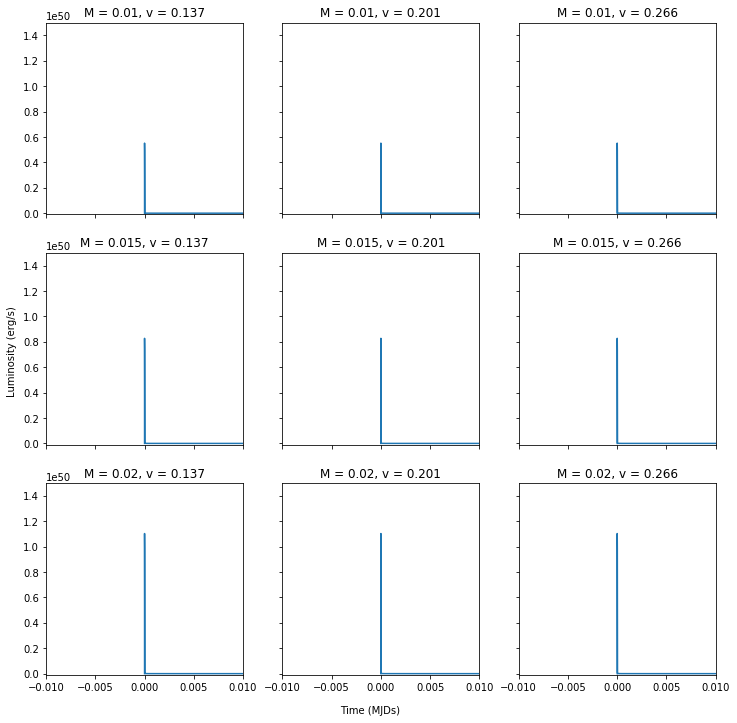

In [23]:
my_engine = mosfit.modules.engines.rprocess.RProcess(name='my_engine', model=my_model)

fig, ax = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(12,12))

for i,k in zip(mejectas, range(3)):
    for j, n in zip(vejectas, range(3)):
        luminosities = my_engine.process( dense_times=dense_times['dense_times'], 
                                          mejecta=i, 
                                          resttexplosion=rest_times['resttexplosion'], 
                                          vejecta=j  )
        
        ax[k,n].plot(dense_times['dense_times'], luminosities['luminosities'])
        ax[k,n].set_title('M = ' + str(i) + ', v = ' + str(j/  (mosfit.constants.C_CGS /mosfit.constants.KM_CGS)))
        ax[k,n].set_ylim(-.01e50, 1.5e50)
        ax[k,n].set_xlim(-.01, .01)        
        
fig.text(0.5, .08, 'Time (MJDs)', ha='center')
fig.text(0.08, 0.5, 'Luminosity (erg/s)', va='center', rotation='vertical')

## Transform: Diffusion
[diffusion.py](../notMOSFiT/mosfit/modules/transforms/diffusion.py)

Given luminosities from the engine, it modifies them to model diffusion of photons through matter, as described in [Arnett 1982](https://ui.adsabs.harvard.edu/#abs/1982ApJ...253..785A/abstract). Specifically, it returns a time scale (Eqn. 18):

$$ \tau_m^2 = 2\tau_0\tau_h $$


or, as given in  [Nicholl et al. 2017](https://ui.adsabs.harvard.edu/#abs/2017ApJ...850...55N/abstract), Eqn. 6,

$$ t_{diff} = \Big( \frac{2\kappa M_{ej}}{\beta c \nu_{ej}} \Big) $$ 

and the leakage paramater (or trap_coeff), which controls the fraction of the magnetar input energy that is thermalized in the ejecta

$$ A = \frac{3\kappa_{\gamma}M_{ej}}{4\pi \nu_{ej}^2} $$

Combining these, the output luminosity is given as Eqn.5:

$$ L_{out}(t) = \exp(t/t_{diff})^2 (1 - e^{-At^{-2}}) \int_{0}^{t} 2 F_{in}(t') \frac{t'}{t_{diff}} \exp(t' / t_{diff})^2 \frac{dt'}{t_{diff}}  $$

Inputs: 

Key | Explanation | Units
--- | --- | ---
dense_times | Array of times to evaluate  | MJDs
rest_times | Array of times to evaluate (in rest frame) - use same array  | MJDs
times | rest_times (see transform.py)   | MJDs
mejecta | Mass of ejected material | $M_{\odot}$
resttexplosion | Time of explosion at rest | MJD
vejecta | Velocity of ejected mass | km/s
kappa | Opacity of ejected material to optical | $cm^2 g^{-1}$
kappa_gamma | Opacity of ejected material to gamma rays | $cm^2 g^{-1}$


Outputs:

Key | Explanation
--- | --- 
tau_diffusion | Characteristic time
luminosities | Luminosity after diffusion

Text(0.08,0.5,'Luminosity (erg/s)')

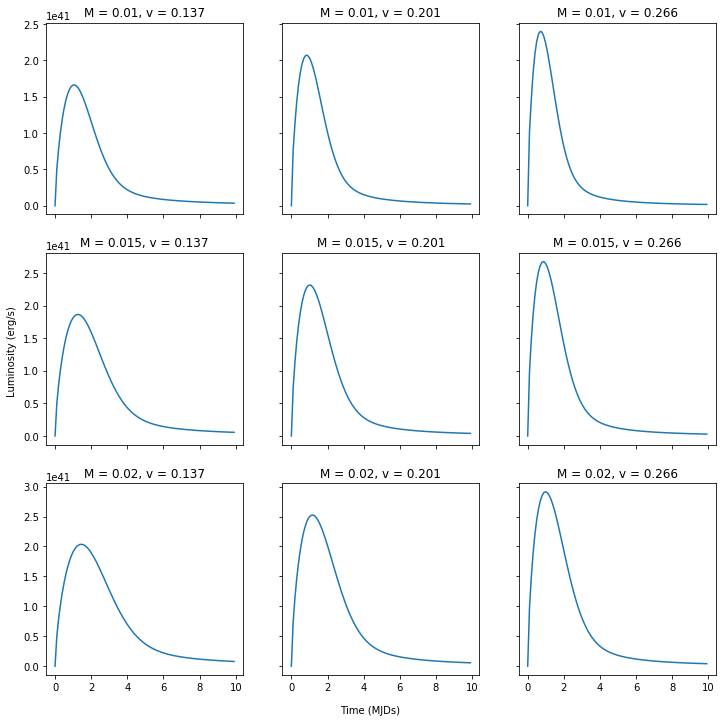

In [24]:
my_transform = mosfit.modules.transforms.diffusion.Diffusion(name='diffusion', model=my_model)


fig, ax = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(12,12))

for i,k in zip(mejectas, range(3)):
    for j, n in zip(vejectas, range(3)):
        luminosities = my_engine.process( dense_times=dense_times['dense_times'], 
                                          mejecta=i, 
                                          resttexplosion=rest_times['resttexplosion'], 
                                          vejecta=j )
        
        new_lums = my_transform.process(dense_times=dense_times['dense_times'], 
                                        mejecta=i, 
                                        resttexplosion=rest_times['resttexplosion'], 
                                        dense_luminosities=luminosities['luminosities'],
                                        kappa=kappa, kappagamma=kappa_gamma, 
                                        rest_times=rest_times['rest_times'], vejecta=j,
                                        times=rest_times['rest_times'])
        
        ax[k,n].plot(rest_times['rest_times'], new_lums['luminosities'], )
        ax[k,n].set_title('M = ' + str(i) + ', v = ' + str(j/  (mosfit.constants.C_CGS /mosfit.constants.KM_CGS)))
       # ax[k,n].set_ylim(-.01e37, 1.e37)
        
fig.text(0.5, .08, 'Time (MJDs)', ha='center')
fig.text(0.08, 0.5, 'Luminosity (erg/s)', va='center', rotation='vertical')

## Photosphere: Temperature Floor
[temperature_floor.py](../notMOSFiT/mosfit/modules/photospheres/temperature_floor.py)

This module returns the temepearture and radius of the photosphere as a function of time. The temeprature is from the Stefan-Boltzmann law, "until the ejecta cools to some critical tempearture." The radius is calculated as $R = vt$, where $v$ is $v_{phot} \approx v_{ejecta}$. This method is outlined in [Nicholl et al 2017](https://ui.adsabs.harvard.edu/#abs/2017ApJ...850...55N/abstract), section 3.6. 

Inputs: 

Key | Explanation | Units
--- | --- | ---
luminosities | Luminosity as a function of time  | $ erg \ s^{-1}$
rest_times | Array of times to evaluate (in rest frame) - use same array  | MJDs
temperature | A final temperature | K
times | Array of times to evaluate - use same array  | MJDs
mejecta | Mass of ejected material | $M_{\odot}$
resttexplosion | Time of explosion at rest | MJD
vejecta | Velocity of ejected mass | km/s
kappa | Opacity of ejected material to optical | $cm^2 g^{-1}$

Outputs:

Key | Explanation | Units
--- | --- | ---
radiusphot | Time-dependent radius of the photosphere | km
temperaturephot | Time-dependent tempearature of the photosphere | K

### Below, I set temperature floor to 0.

Text(0.03,0.5,'Temperature Photosphere (K)')

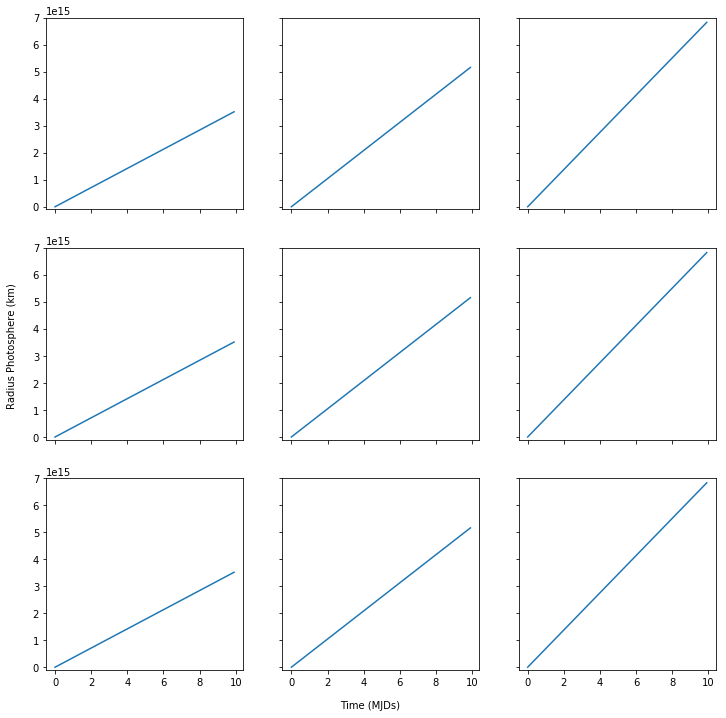

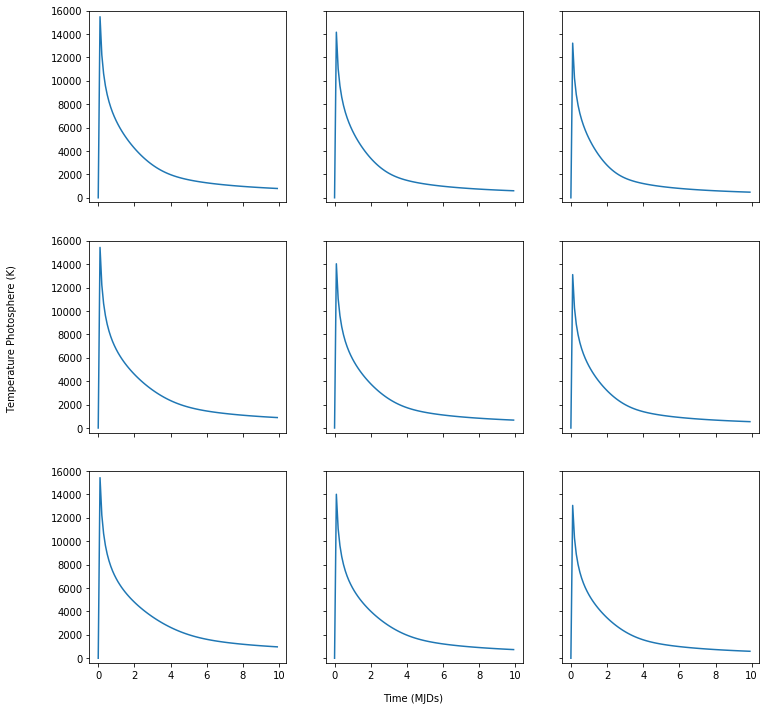

In [25]:
my_photosphere = mosfit.modules.photospheres.temperature_floor.TemperatureFloor(name='tempfloor', model=my_model)

fig1, ax1 = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(12,12))
fig2, ax2 = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(12,12))

for i,k in zip(mejectas, range(3)):
    for j, n in zip(vejectas, range(3)):
        luminosities = my_engine.process( dense_times=dense_times['dense_times'], 
                                          mejecta=i, 
                                          resttexplosion=rest_times['resttexplosion'], 
                                          vejecta=j )
        
        new_lums = my_transform.process(dense_times=dense_times['dense_times'], 
                                        mejecta=i, 
                                        resttexplosion=rest_times['resttexplosion'], 
                                        dense_luminosities=luminosities['luminosities'],
                                        kappa=kappa, kappagamma=kappa_gamma, 
                                        rest_times=rest_times['rest_times'], vejecta=j,
                                        times=rest_times['rest_times'])
        
        
        photosphere_output = my_photosphere.process(
                                        mejecta=i, 
                                        resttexplosion=rest_times['resttexplosion'], 
                                        luminosities=new_lums['luminosities'],
                                        temperature=0, kappa=kappa, 
                                        vejecta=j,
                                        rest_times=rest_times['rest_times'])
        
        ax1[k,n].plot(rest_times['rest_times'], photosphere_output['radiusphot'])
        ax[k,n].set_title('M = ' + str(i) + ', v = ' + str(j/  (mosfit.constants.C_CGS /mosfit.constants.KM_CGS)))
        ax1[k,n].set_ylim(-.1e15, 7e15)
        
        ax2[k,n].plot(rest_times['rest_times'], photosphere_output['temperaturephot'])
        ax[k,n].set_title('M = ' + str(i) + ', v = ' + str(j/  (mosfit.constants.C_CGS /mosfit.constants.KM_CGS)))
        ax2[k,n].set_ylim(-400, 16000)
        
fig1.text(0.5, .08, 'Time (MJDs)', ha='center')
fig1.text(0.08, 0.5, 'Radius Photosphere (km)', va='center', rotation='vertical')
        
fig2.text(0.5, .08, 'Time (MJDs)', ha='center')
fig2.text(0.03, 0.5, 'Temperature Photosphere (K)', va='center', rotation='vertical')

## SED: Blackbody
[blackbody.](../notMOSFiT/mosfit/modules/seds/blackbody.py)

The blackbody module returns the spectrum of the object as a function of time. The blackbody class inherits from the SED class. The spectra is calculated from the Planck formula. More information can be found in  [Nicholl et al 2017](https://ui.adsabs.harvard.edu/#abs/2017ApJ...850...55N/abstract), section 3.7. 

Inputs: 

Key | Explanation | Units
--- | --- | ---
luminosities | Luminosity as a function of time  | $$ erg \ s^{-1} $$
all_bands | Bands to return observations in | list of strings
all_band_indices | An internal band-matched index corresponding to all bands | list of ints
all_frequencies | For count-based observations (ignore)  | -
radiusphot | Time-dependent radius of the photosphere | km?
redshift | Redshift of event | z
sample_wavelengths | Wavelengths for which to evaluate SED | nm

Outputs:

Key | Explanation | Units
--- | --- | ---
sample_wavelengths | Wavelengths of the SED | nm
seds | A list of np.arrays corresponding to an SED for each time that luminosities was evaluated in | erg, probably

In [26]:
# Cheating gently to get the output of the SED
my_blackbody = mosfit.modules.seds.blackbody.Blackbody(name='bb', model=my_model)
my_blackbody._sample_wavelengths = sample_wavs

Text(0.08,0.5,'Energy (erg)')

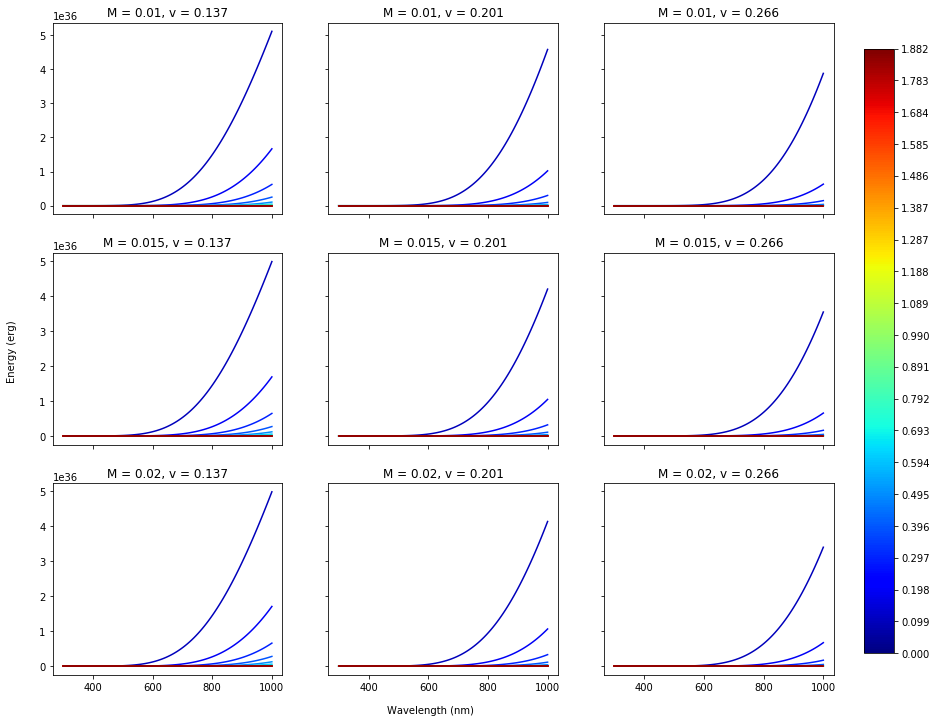

In [28]:
fig, ax = plt.subplots(3, 3, sharex='col', sharey='row',   figsize=(14,12))

c = rest_times['rest_times'][0:20]

norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.jet)
cmap.set_array([])
                       
for i,k in zip(mejectas, range(3)):
    for j, n in zip(vejectas, range(3)):
        luminosities = my_engine.process( dense_times=dense_times['dense_times'], 
                                          mejecta=i, 
                                          resttexplosion=rest_times['resttexplosion'], 
                                          vejecta=j )
        
        new_lums = my_transform.process(dense_times=dense_times['dense_times'], 
                                        mejecta=i, 
                                        resttexplosion=rest_times['resttexplosion'], 
                                        dense_luminosities=luminosities['luminosities'],
                                        kappa=kappa, kappagamma=kappa_gamma, 
                                        rest_times=rest_times['rest_times'], vejecta=j,
                                        times=rest_times['rest_times'])
        
        
        photosphere_output = my_photosphere.process(
                                        mejecta=i, 
                                        resttexplosion=rest_times['resttexplosion'], 
                                        luminosities=new_lums['luminosities'],
                                        temperature=0, kappa=kappa, 
                                        vejecta=j,
                                        rest_times=rest_times['rest_times'])
        
        
        bb_output = my_blackbody.process(luminosities=new_lums['luminosities'],
                                 all_bands = times['all_bands'],
                                 all_band_indices=band_indices,
                                 all_frequencies=frequencies,
                                 radiusphot=photosphere_output['radiusphot'],
                                temperaturephot=photosphere_output['temperaturephot'],
                                redshift=redshift)

        for m, color in enumerate(c):
            ax[k,n].plot(bb_output['sample_wavelengths'][m], bb_output['seds'][m], c=cmap.to_rgba(color))
        ax[k,n].set_title('M = ' + str(i) + ', v = ' + str(j/  (mosfit.constants.C_CGS /mosfit.constants.KM_CGS)))

        
cbar_ax = fig.add_axes([.93, 0.15, 0.03, 0.7])
fig.colorbar(cmap, ticks=c, cax=cbar_ax)
fig.text(0.5, .08, 'Wavelength (nm)', ha='center')
fig.text(0.08, 0.5, 'Energy (erg)', va='center', rotation='vertical')

This is the point at which I would attempt to try to plot actual observables, but to be perfectly honest? It works when you run mosfit from the command line, and that's good enough for me. 